In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from os import listdir
from os.path import isfile, join
import numpy as np 
import tensorflow as tf
from PIL import Image as img
from tensorflow.python import keras
from keras import Sequential, datasets, layers, models
import pickle as pk

In [2]:
pixels = 128
dimensions = (pixels, pixels)
bins = 5
mid_layer = 512
num_epochs = 3
learning_rate = 0.01
reduction_factor = 0.7

In [3]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = old_lr * reduction_factor
        print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
        self.model.optimizer.lr.assign(new_lr)

In [4]:
train_images = []
train_labels = np.array([])
filenames = []

folder_path = '/mnt/c/NN/Diabetic Retinopathy/'

for i in range(5):
    j = 0
    for f in listdir(folder_path + str(i)):
        im = img.open(folder_path + str(i) + '/' + f)
        im = im.resize(dimensions)
        im = im.convert('L')
        im_array = np.array(im)
        im.close()
        train_images.append(im_array)
        train_labels = np.append(train_labels, i)  
        filenames.append(f)
        j += 1
        if j == 708:
            break   

In [5]:
train_images = np.array(train_images)

In [ ]:
# temp = np.zeros((len(train_labels), pixels, pixels, 3))
# for i in range(len(train_labels)):
    # temp[i, :, :, 0] = train_images[i, :, :]
    # temp[i, :, :, 1] = train_images[i, :, :]
    # temp[i, :, :, 2] = train_images[i, :, :]
# train_images = temp

In [6]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(filenames))

(3540, 128, 128)
(3540,)
(3540,)


In [8]:
randomize = np.arange(len(train_images))
np.random.shuffle(randomize)
train_images = train_images[randomize]
train_labels = train_labels[randomize]
temp = filenames.copy()
for i in range(len(train_images)):
    temp[i] = filenames[randomize[i]]
filenames = temp.copy()

test_images = train_images[int(len(train_labels) * 0.8):, :, :]
test_labels = train_labels[int(len(train_labels) * 0.8):]
test_filenames = filenames[int(len(train_labels) * 0.8):]

train_images = train_images[:int(len(train_labels) * 0.8), :, :]
train_labels = train_labels[:int(len(train_labels) * 0.8)]
train_filenames = filenames[:int(len(train_labels) * 0.8)]

train_images = np.squeeze(train_images) / 255.0
test_images = np.squeeze(test_images) / 255.0

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

In [9]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(2832, 128, 128)
(2832,)
(708, 128, 128)
(708,)


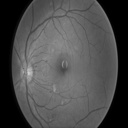

2.0
14323_right.jpeg


In [11]:
to_show = 2
img.fromarray(255 * train_images[to_show, :, :]).show()
print(train_labels[to_show])
print(train_filenames[to_show])

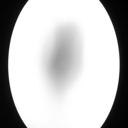

0.0
10440_left.jpeg


In [12]:
to_show = 3
img.fromarray(255 * test_images[to_show, :, :]).show()
print(test_labels[to_show])
print(test_filenames[to_show])

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(pixels, pixels, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(bins, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, callbacks=[LearningRateReducerCb()], epochs=num_epochs,
                    validation_data=(test_images, test_labels))